In [1]:
import networkx as nx
import random
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from cdlib import algorithms
from cdlib import evaluation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from scipy import stats
import os
from tqdm import tqdm as tqdm
import pickle
from node2vec import Node2Vec
# from ipywidgets import *

In [ ]:
def read_file (filename):
    
    G = {}
    
    with open(filename) as file:
        for line in file:
            data = line.strip().split()
            l = int(data[0])
            n = int(data[1])
            m = int(data[2])
            if l not in G:
                G[l] = nx.Graph()
            G[l].add_edge(n,m)
    
    return G

#############

In [ ]:
def duplex_network (G, l1, l2):
    
    G1 = G[l1].copy()
    G2 = G[l2].copy()
    
    ##delete common edges
    list_of_common_edges = []
    
    for e in G[l1].edges():
        if G[l2].has_edge(e[0], e[1]):
            list_of_common_edges.append([e[0], e[1]])
            
            
    print ('# Overlap : ', len(list_of_common_edges))
    print ('# Jaccard index : ', len(list_of_common_edges) / (len(G[l1].edges()) + len(G[l2].edges()) - len(list_of_common_edges)))
    
    
    for e in list_of_common_edges:
        G1.remove_edge(e[0], e[1])
        G2.remove_edge(e[0], e[1])
        
    
    
    ##delete nodes with zero degree
    list_of_nodes = []
    for n in G1.nodes():
        if G1.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.remove_node(n)
        
    list_of_nodes = []
    for n in G2.nodes():
        if G2.degree(n)==0:
            list_of_nodes.append(n)
    for n in list_of_nodes:
        G2.remove_node(n)
            
    

    ##create union of nodes
    list_of_nodes = []
    for n in G1.nodes():
        list_of_nodes.append(n)
    for n in G2.nodes():
        list_of_nodes.append(n)
    for n in list_of_nodes:
        G1.add_node(n)
        G2.add_node(n)
        
        
        

    return G1, G2


#######

def partial_information (G1, G2, frac):
    
    
#     print ('# option = ', option)
    
    ##training/test sets
    Etest = {}
    Etrain = {}
    
    for e in G1.edges():
        if random.random() < frac:
            Etrain[e] = 1
        else:
            Etest[e] = 1
            
    for e in G2.edges():
        if random.random() < frac:
            Etrain[e] = 0
        else:
            Etest[e] = 0
        
        
    
    ##remnants
    rem_G1 = nx.Graph()
    rem_G2 = nx.Graph()
    for n in G1:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
    for n in G2:
        rem_G1.add_node(n)
        rem_G2.add_node(n)
        
        
    
    for e in Etest:
        rem_G1.add_edge(e[0], e[1])
        rem_G2.add_edge(e[0], e[1])
            
    
    for e in Etrain:
        if Etrain[e] == 1:
            rem_G1.add_edge(e[0], e[1])
        if Etrain[e] == 0:
            rem_G2.add_edge(e[0], e[1])
    
    
    return rem_G1, rem_G2, Etest 


#####


def community_finder (G, method = 'louvain'):
    
#     print ('#3 method : ', method)
    
    if method == 'louvain':
        C = algorithms.louvain(G)
    if method == 'infomap':
        C = algorithms.infomap(G)
    sigma = {}
    c = 0
    for r in C.communities:
        for q in r:
            sigma[q] = c
        c = c + 1
        
    mu = tot = 0.0
    for n in G.nodes():
        for m in G.neighbors(n):
            tot += 1.0
            if sigma[n] == sigma[m]:
                mu += 1.0
            
        
    return sigma, mu, tot





def classifier (rem_G1, rem_G2, Etest, TT = 0, show_log = False, method = 'louvain'):
    
#     print ('#2 method : ', method)
    
    ## degree/community
    if TT == 0:
        sigma1, mu1, tot1 = community_finder(rem_G1, method = method)
        sigma2, mu2, tot2 = community_finder(rem_G2, method = method)
        
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)


        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
            if show_log == True: 
                print (mu)
                print (rem_G1.degree(n), rem_G1.degree(m), t1)
                print (rem_G2.degree(n), rem_G2.degree(m), t2)
                print (Etest[e], '\n')
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
    
    ## degree
    if TT == 1:
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = rem_G1.degree(n)*rem_G1.degree(m)    
            s2 = rem_G2.degree(n)*rem_G2.degree(m)
            
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                   
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
        return classification, scores, ground_truth
    
        
        
        
    ## community
    if TT == 2:
        sigma1, mu1, tot1 = community_finder(rem_G1)
        sigma2, mu2, tot2 = community_finder(rem_G2)
        
        mu = 0.5
        if tot1 + tot2 > 0.0:
            mu = (mu1 + mu2) / (tot1 + tot2)
        
        
        classification, scores, ground_truth = [], [], []
        
        for e in Etest:
            
                
            n = e[0]
            m = e[1]
            
            s1 = 1.0
            if sigma1[n] == sigma1[m]:
                s1 = s1 * mu
            else:
                s1 = s1 * (1.0-mu)
                
                
                
            s2 = 1.0
            if sigma2[n] == sigma2[m]:
                s2 = s2 * mu
            else:
                s2 = s2 * (1.0-mu)
                
            
            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)
            
            
            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0
                
                
            
            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])
            
                
    
        return classification, scores, ground_truth
    
        
        
    
####


def perform_analysis (G1, G2, step, TT = 0, method = 'louvain'):
    
    
    #print ('# option = ', option)
    
#     print (' #1 method : ', method)
    
    
    x , y, z  = [], [], []
    
    
    frac = 0.0
    while frac < 1.0:
        
        if frac <= 1.0 - step:
            
#             print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))
            
            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT = TT, method=method)
            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)
            
            
            
            x.append(frac)
            y.append(acc)
            z.append(auc)
            
            
        frac += step
        
        
    results = [x, y, z]
    return results

In [ ]:
def renormalize_embedding_per_component (G, n2v_emb):

    n2v_emb_rescaled = {}
    for n in G:
        n2v_emb_rescaled[n] = n2v_emb.wv[str(n)]



    nr_comp = 0
    components = nx.connected_components(G)
    for c in components:
        nr_comp += 1
        list_of_nodes = []
        norm = 0.0
        for n in c:
            list_of_nodes.append(n2v_emb_rescaled[n])
        cm = np.add.reduce(list_of_nodes) / float(len(list_of_nodes))
        for n in c:
            n2v_emb_rescaled[n] = n2v_emb_rescaled[n] - cm
            norm += np.linalg.norm(n2v_emb_rescaled[n])
        if norm > 0.0:
            for n in c:
                n2v_emb_rescaled[n] = n2v_emb_rescaled[n] / norm


#     #######
#     nr_comp = 0
#     components = nx.connected_components(G)
#     for c in components:
#         nr_comp += 1
#         list_of_nodes = []
#         for n in c:
#             list_of_nodes.append(n2v_emb_rescaled[n])
#         cm = np.add.reduce(list_of_nodes) / float(len(list_of_nodes))
#         norm = 0.0
#         for n in c:
#             norm += np.linalg.norm(n2v_emb_rescaled[n])
#         print ('norm = ', norm, ' cm = ', np.linalg.norm(cm, ord = 1))




    return n2v_emb_rescaled

############

def score_edges_training (rem_G1, emb_rescaled_1, rem_G2, emb_rescaled_2, penalty):


    ####################################
    degree_score = {}
    emb_score = {}
    ground_truth = {}

    for e in rem_G1.edges():

        n = e[0]
        m = e[1]

        tmp1 = rem_G1.degree(n)*rem_G1.degree(m)
        tmp2 = rem_G2.degree(n)*rem_G2.degree(m)

        stmp1 = 1.0/(np.linalg.norm(emb_rescaled_1[n] - emb_rescaled_1[m]) + penalty)
        stmp2 = 1.0/(np.linalg.norm(emb_rescaled_2[n] - emb_rescaled_2[m]) + penalty)

        if n < m:
            degree_score[n,m] = tmp1/(tmp1+tmp2)
            emb_score[n,m] = stmp1/(stmp1+stmp2)
            ground_truth[n,m] = 1
        else:
            degree_score[m,n] = tmp1/(tmp1+tmp2)
            emb_score[m,n] = stmp1/(stmp1+stmp2)
            ground_truth[m,n] = 1


    for e in rem_G2.edges():

        n = e[0]
        m = e[1]

        tmp1 = rem_G1.degree(n)*rem_G1.degree(m)
        tmp2 = rem_G2.degree(n)*rem_G2.degree(m)

        stmp1 = 1.0/(np.linalg.norm(emb_rescaled_1[n] - emb_rescaled_1[m]) + penalty)
        stmp2 = 1.0/(np.linalg.norm(emb_rescaled_2[n] - emb_rescaled_2[m]) + penalty)

        if n < m:
            degree_score[n,m] = tmp1/(tmp1+tmp2)
            emb_score[n,m] = stmp1/(stmp1+stmp2)
            ground_truth[n,m] = 0
        else:
            degree_score[m,n] = tmp1/(tmp1+tmp2)
            emb_score[m,n] = stmp1/(stmp1+stmp2)
            ground_truth[m,n] = 0
    ###########################

#     for e in degree_score:
#         print (e, degree_score[e], emb_score[e], ground_truth[e])

    return degree_score, emb_score, ground_truth

In [ ]:
def perform_logisitic_regression (degree_score, emb_score, ground_truth, option):

    list_of_edges = list(degree_score.keys())

    #degree only
    if option == 1 or option == 2:

        X = np.zeros((len(list_of_edges),1))
        y = np.zeros(len(list_of_edges))

        for i in range(0,len(list_of_edges)):
            X[i][0] = 2.0*degree_score[list_of_edges[i]]-1.0
            y[i] = ground_truth[list_of_edges[i]]

        if option == 1:
            print ('# option 1 , degree only')
            log_regression = LogisticRegression(fit_intercept=False, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Degree coefficient = ', log_regression.coef_[0][0])

        if option == 2:
            print ('# option 2 , degree + intercept')
            log_regression = LogisticRegression(fit_intercept=True, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Intercept = ', log_regression.intercept_[0])
            print('#Degree coefficient = ', log_regression.coef_[0][0])

        return log_regression



    #embedding only
    if option == 3 or option == 4:

        X = np.zeros((len(list_of_edges),1))
        y = np.zeros(len(list_of_edges))

        for i in range(0,len(list_of_edges)):
            X[i][0] = 2.0*emb_score[list_of_edges[i]]-1.0
            y[i] = ground_truth[list_of_edges[i]]

        if option == 3:
            print ('# option 3 , embedding only')
            log_regression = LogisticRegression(fit_intercept=False, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Embedding coefficient = ', log_regression.coef_[0][0])

        if option == 4:
            print ('# option 4 , embedding + intercept')
            log_regression = LogisticRegression(fit_intercept=True,  penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Intercept = ', log_regression.intercept_[0])
            print('#Embedding coefficient = ', log_regression.coef_[0][0])

        return log_regression





    if option == 5 or option == 6:

        X = np.zeros((len(list_of_edges),2))
        y = np.zeros(len(list_of_edges))

        for i in range(0,len(list_of_edges)):
            X[i][0] = 2.0*degree_score[list_of_edges[i]]-1.0
            X[i][1] = 2.0*emb_score[list_of_edges[i]]-1.0
            y[i] = ground_truth[list_of_edges[i]]

        if option == 5:
            print ('# option 5 , degree + embedding')
            log_regression = LogisticRegression(fit_intercept=False,  penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Degree coefficient = ', log_regression.coef_[0][0])
            print('#Embedding coefficient = ', log_regression.coef_[0][1])

        if option == 6:
            log_regression = LogisticRegression(fit_intercept=True, penalty='none').fit(X, y)
            print('#Training set score ', log_regression.score(X, y))
            print('#Intercept = ', log_regression.intercept_[0])
            print('#Degree coefficient = ', log_regression.coef_[0][0])
            print('#Embedding coefficient = ', log_regression.coef_[0][1])

        return log_regression

In [ ]:
def embedding_classifier (Etest, rem_G1, emb_rescaled_1, rem_G2, emb_rescaled_2, log_regression, penalty, option):

#     print('#Intercept = ', log_regression.intercept_[0])
#     print('#Degree coefficient = ', log_regression.coef_[0][0])
#     print('#Embedding coefficient = ', log_regression.coef_[0][1])

    classification, scores, ground_truth = [], [], []



    for e in Etest:
        n = e[0]
        m = e[1]


        ##degree
        s1 = rem_G1.degree(n)*rem_G1.degree(m)
        s2 = rem_G2.degree(n)*rem_G2.degree(m)

        t1 = t2 = 0.5
        if s1 + s2 > 0.0:
            t1 = s1 / (s1 + s2)
            t2 = s2 / (s1 + s2)
        t1 = 2.0*t1-1.0
        t2 = 2.0*t2-1.0
        ##embedding

        es1 = 1.0/(np.linalg.norm(emb_rescaled_1[n] - emb_rescaled_1[m]) + penalty)
        es2 = 1.0/(np.linalg.norm(emb_rescaled_2[n] - emb_rescaled_2[m]) + penalty)

        et1 = et2 = 0.5
        if es1 + es2 > 0.0:
            et1 = es1 / (es1 + es2)
            et2 = es2 / (es1 + es2)
        et1 = 2.0*et1-1.0
        et2 = 2.0*et2-1.0
        ###########


        if option == 1:
#             print ('# option 1 , degree only')
            prob1 = log_regression.coef_[0][0] * t1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 2:
#             print ('# option 2 , degree + intercept')
            prob1 = log_regression.intercept_[0] + log_regression.coef_[0][0] * t1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 3:
#             print ('# option 3 , embedding only')
            prob1 = log_regression.coef_[0][0] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 4:
#             print ('# option 4 , embedding + intercept')
            prob1 = log_regression.intercept_[0] + log_regression.coef_[0][0] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 5:
#             print ('# option 5 , degree + embedding')
            prob1 = log_regression.coef_[0][0] * t1 + log_regression.coef_[0][1] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1

        if option == 6:
#             print ('# option 6 , degree + embedding + intercept')
            prob1 = log_regression.intercept_[0] + log_regression.coef_[0][0] * t1 + log_regression.coef_[0][1] * et1
            prob1 = 1.0 / (1.0 + np.exp(-prob1))
            prob2 = 1.0 - prob1



        s = random.randint(0,1)
        if prob1 > prob2:
            s = 1
        if prob2 > prob1:
            s = 0



        scores.append(prob1)
        classification.append(s)
        ground_truth.append(Etest[e])



    return classification, scores, ground_truth


In [ ]:
def perform_analysis_embedding (G1, G2, step, option = 1, penalty = 0.1):



    x , y, z  = [], [], []


    frac = step
    while frac < 1.0:

        if frac <= 1.0 - step:

            print('\n\nFrac ', frac)

            rem_G1, rem_G2, Etest  = partial_information (G1, G2, frac)

            node2vec1 = Node2Vec(rem_G1, dimensions=62, walk_length=20, num_walks=10, workers=16)
            node2vec2 = Node2Vec(rem_G2, dimensions=64, walk_length=20, num_walks=10, workers=16)

            model1 = node2vec1.fit(window=10, min_count=1, batch_words=4)
            model2 = node2vec2.fit(window=10, min_count=1, batch_words=4)

            n2v_emb_rescaled_1 = renormalize_embedding_per_component (rem_G1, model1)
            n2v_emb_rescaled_2 = renormalize_embedding_per_component (rem_G2, model2)

            degree_score, emb_score, ground_truth = score_edges_training (rem_G1, n2v_emb_rescaled_1, rem_G2, n2v_emb_rescaled_2, penalty)


            log_regression = perform_logisitic_regression (degree_score, emb_score, ground_truth, option)

            classification, scores, ground_truth = embedding_classifier (Etest, rem_G1, n2v_emb_rescaled_1, rem_G2, n2v_emb_rescaled_2, log_regression, penalty, option)

            acc = metrics.accuracy_score(ground_truth, classification)
            auc = metrics.roc_auc_score(ground_truth, scores)



            x.append(frac)
            y.append(acc)
            z.append(auc)


        frac += step


    results = [x, y, z]
    return results

## Figure 4b

In [ ]:
# 1 Direct interaction
# 2 Suppressive genetic interaction defined by inequality
# 3 Additive genetic interaction defined by inequality
# 4 Physical association
# 5 Colocalization
# 6 Association
# 7 Synthetic genetic interaction defined by inequality


# ! >>>
filename = "../../data/input/raw/duplex_system=drosophila.edgelist"
# ! <<<
# filename = '../FIGURES/Figure4bis/Data/multiplex_network-drosophila.edgelist'
# filename = '../FIGURES/Figure4bis/Data/multiplex_network-london.edgelist'
# filename = '../FIGURES/Figure4bis/Data/rattus_genetic_multiplex.edges'
# filename = '../FIGURES/Figure4bis/Data/multiplex_network-celegans.edgelist'
G = read_file (filename)

In [ ]:
results = {}
step = 0.1

In [ ]:
l1 = 1
l2 = 2
G1, G2 = duplex_network (G, l1, l2)

#############


print ('# Number of nodes ', len(G1.nodes()))
print ('# Number of edges ', len(G1.edges()))

print ('# Number of nodes ', len(G2.nodes()))
print ('# Number of edges ', len(G2.edges()))


#############

print('# Louvain')



C1 = algorithms.louvain(G1)
mod1 = evaluation.newman_girvan_modularity(G1,C1)
print ('# Modularity ', mod1.score)

C2 = algorithms.louvain(G2)
mod2 = evaluation.newman_girvan_modularity(G2,C2)
print ('# Modularity ', mod2.score)

nmi = evaluation.normalized_mutual_information(C1, C2)
print ('# NMI ', nmi.score)


#############



method = 'louvain'
tmp = {}
T = 10
for t in range(T):
    tmp[t] = perform_analysis (G1, G2, step, 2, method)
results[method, l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results[method, l1, l2][0,q] += tmp[t][0][q]/float(T)
        results[method, l1, l2][1,q] += tmp[t][1][q]/float(T)
        results[method, l1, l2][2,q] += tmp[t][2][q]/float(T)

# Overlap :  66
# Jaccard index :  0.0025606207565470416
# Number of nodes  7519
# Number of edges  23911
# Number of nodes  7519
# Number of edges  1798
# Louvain
# Modularity  0.4573398817458598
# Modularity  0.6297192777539233
# NMI  0.4924862549503316


In [25]:
method = 'node2vec'
penalty = 0.01
option = 3
tmp = {}
T = 1
for t in range(T):
    tmp[t] = perform_analysis_embedding (G1, G2, step, option, penalty)
results[method, l1, l2] = np.zeros((3,len(tmp[0][0])))
for t in tmp:
    for q in range(len(tmp[t][0])):
        results[method, l1, l2][0,q] += tmp[t][0][q]/float(T)
        results[method, l1, l2][1,q] += tmp[t][1][q]/float(T)
        results[method, l1, l2][2,q] += tmp[t][2][q]/float(T)




Frac  0.1


Generating walks (CPU: 8): 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:05<00:00,  5.83s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:04<00:00,  4.59s/it]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 100%|██████████| 1/1 [00:08<00:00,  8.31s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:09<00:00,  9.19s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:09<00:00,  9.58s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]

# option 3 , embedding only
#Training set score  0.4364619393986542
#Embedding coefficient =  0.045397591816984925


Frac  0.2


Generating walks (CPU: 6): 100%|██████████| 1/1 [00:08<00:00,  8.31s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:06<00:00,  6.86s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:05<00:00,  5.88s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:07<00:00,  7.59s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (

# option 3 , embedding only
#Training set score  0.44167412190283556
#Embedding coefficient =  0.09368000025680237


Frac  0.30000000000000004


Generating walks (CPU: 5): 100%|██████████| 1/1 [00:05<00:00,  5.20s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:05<00:00,  5.43s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:06<00:00,  6.21s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:08<00:00,  8.01s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:05<00:00,  5.67s/it

# option 3 , embedding only
#Training set score  0.4726360418530476
#Embedding coefficient =  0.7170261526182927


Frac  0.4


Generating walks (CPU: 7): 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:09<00:00,  9.02s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 5): 100%|██████████| 1/1 [00:08<00:00,  8.18s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:08<00:00,  8.49s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (C

# option 3 , embedding only
#Training set score  0.5213349410712202
#Embedding coefficient =  0.6817455329441374


Frac  0.5


Generating walks (CPU: 6): 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:08<00:00,  8.57s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 5): 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:05<00:00,  6.00s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:05<00:00,  5.

# option 3 , embedding only
#Training set score  0.5627601229141546
#Embedding coefficient =  0.8396552553450947


Frac  0.6


Generating walks (CPU: 6): 100%|██████████| 1/1 [00:09<00:00,  9.57s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:08<00:00,  8.75s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:06<00:00,  6.58s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 5): 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:08<00:00,  8.69s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:08<00:00,  8.

# option 3 , embedding only
#Training set score  0.616904585942666
#Embedding coefficient =  1.4128440785977825


Frac  0.7


Generating walks (CPU: 6): 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 3): 100%|██████████| 1/1 [00:06<00:00,  6.89s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 7): 100%|██████████| 1/1 [00:06<00:00,  6.02s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (

# option 3 , embedding only
#Training set score  0.6699988330934692
#Embedding coefficient =  1.575369130154452


Frac  0.7999999999999999


Generating walks (CPU: 7): 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 8): 100%|██████████| 1/1 [00:05<00:00,  5.79s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:05<00:00,  5.28s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 5): 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:05<00:00,  5.17s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (

# option 3 , embedding only
#Training set score  0.722509626978879
#Embedding coefficient =  2.0327296272987603


Frac  0.8999999999999999


Generating walks (CPU: 6): 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 9): 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 10): 100%|██████████| 1/1 [00:06<00:00,  6.86s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (CPU: 15): 0it [00:00, ?it/s]
Generating walks (CPU: 16): 0it [00:00, ?it/s]
Generating walks (CPU: 2): 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
Generating walks (CPU: 11): 0it [00:00, ?it/s]
Generating walks (CPU: 4): 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
Generating walks (CPU: 12): 0it [00:00, ?it/s]
Generating walks (CPU: 5): 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]
Generating walks (CPU: 13): 0it [00:00, ?it/s]
Generating walks (CPU: 6): 100%|██████████| 1/1 [00:04<00:00,  4.43s/it]
Generating walks (CPU: 14): 0it [00:00, ?it/s]
Generating walks (

# option 3 , embedding only
#Training set score  0.737718308763468
#Embedding coefficient =  2.639323107113853


(0.0, 1.0)

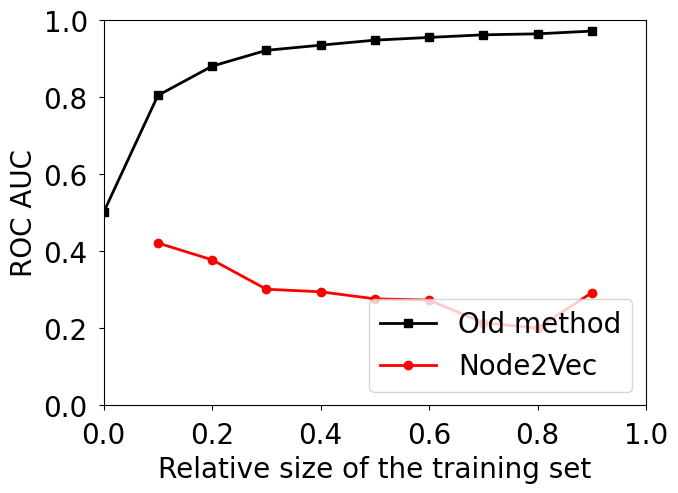

In [26]:
fig = plt.figure()
fig.set_size_inches(7,5)
plt.rc('text', usetex=False)
plt.rc('font', size=20, **{'family':'DejaVu Sans','sans-serif':['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8


plt.plot(results['louvain', l1, l2][0], results['louvain', l1, l2][2], marker='s', linewidth=2, color = 'black', label='Old method')
plt.plot(results['node2vec', l1, l2][0], results['node2vec', l1, l2][2], marker='o', linewidth=2, color = 'red', label='Node2Vec')


plt.legend(loc='lower right')
plt.xlabel('Relative size of the training set')
plt.ylabel('ROC AUC')
plt.ylim(.0,1)
plt.xlim(.0,1)